In [4]:
import numpy as np 
from numpy.linalg import pinv
from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
class LinTS:
    def __init__(self, d, sigma, lambda_reg=1.0, alpha=1.0):
        """
        LinTS algorithm for linear contextual bandits.

        Parameters:
        - d: Dimension of the action space.
        - sigma: Standard deviation of the noise (assumes sub-Gaussian noise).
        - lambda_reg: Regularization parameter for the covariance matrix.
        - alpha: Scaling factor for exploration (optional, typically set to 1.0).
        """
        self.d = d  # Dimension of the feature space
        self.sigma = sigma  # Noise standard deviation
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.alpha = alpha  # Exploration scaling factor
        self.reset()

    def reset(self):
        """
        Reset all internal estimators and counters for independent experiments.
        """
        self.t = 0  # Time step counter
        self.hat_theta = np.zeros(self.d)  # Estimated parameter vector
        self.cov = 1/self.lambda_reg * np.identity(self.d)  # Covariance matrix (B_t)
        self.invcov = pinv(self.cov)  # Inverse of the covariance matrix
        self.b_t = np.zeros(self.d)  # Accumulated rewards vector

    def get_action(self, arms):
        """
        Choose an action using the LinTS strategy.

        Parameters:
        - arms: Array of shape (K, d) representing the available actions.

        Returns:
        - The chosen action (vector of dimension d).
        """
        # Sample a parameter vector from the posterior distribution
        sampled_theta = np.random.multivariate_normal(self.hat_theta, self.invcov)
        estimated_rewards = np.dot(arms, sampled_theta)
        best_arm_idx = np.argmax(estimated_rewards) # Choose the action with the highest estimated reward
        return arms[best_arm_idx]

    def receive_reward(self, chosen_arm, reward):
        """
        Update the internal model with the observed reward for the chosen action.

        Parameters:
        - chosen_arm: The action (vector) that was chosen.
        - reward: The observed reward.
        """
        # Update covariance matrix and its inverse
        self.cov += 1/self.sigma**2*np.outer(chosen_arm, chosen_arm)
        self.invcov = pinv(self.cov)

        # Update the b_t vector with the reward
        self.b_t += 1/self.sigma**2*(reward * chosen_arm)

        # Update the least squares estimate of theta
        self.hat_theta = np.dot(self.invcov, self.b_t)
        self.t += 1

    def name(self):
        """
        Returns the name of the algorithm for identification.
        """
        return f'LinTS(alpha={self.alpha})'

In [4]:
def play(environment, agent, Nmc, T, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    """

    data = np.zeros((Nmc, T))



    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              # pseudo-regret removes some of the noise and corresponds to the metric studied in class
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive

    return agent.name(), data


def experiment(environment, agents, Nmc, T,pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T,pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

In [19]:
def ActionsGenerator(K, d, mean=None):
    """
    Generate K actions in a d-dimensional space uniformly sampled on the unit sphere.

    Parameters:
    - K (int): Number of actions to generate.
    - d (int): Dimension of the action space.
    - mean (array-like, optional): Mean vector for generating actions. Defaults to the origin.

    Returns:
    - np.ndarray: An array of shape (K, d) with K action vectors uniformly distributed on the unit sphere.
    """
    # Generate K random points from a normal distribution
    random_points = np.random.normal(size=(K, d))
    
    # Normalize each vector to lie on the unit sphere
    norms = np.linalg.norm(random_points, axis=1, keepdims=True)
    unit_sphere_points = random_points / norms

    # Optionally adjust the mean of the distribution
    if mean is not None:
        mean = np.array(mean).reshape(1, -1)  # Ensure mean is compatible with unit_sphere_points
        unit_sphere_points += mean
        # Re-normalize to ensure points still lie on the sphere
        unit_sphere_points = unit_sphere_points / np.linalg.norm(unit_sphere_points, axis=1, keepdims=True)

    return unit_sphere_points

In [6]:
class LinearBandit:

    def __init__(self, theta, K, var=1., fixed_actions=None):
      """
      theta: d-dimensional vector (bounded) representing the hidden parameter
      K: number of actions per round (random action vectors generated each time)
      pb_type: string in 'fixed', 'iid', 'nsr' (please ignore NotSoRandom)
      """
      self.d = np.size(theta)
      self.theta = theta
      self.K = K
      self.var = var
      self.current_action_set = np.zeros(self.d)
      if fixed_actions is not None:
         self.pb_type = 'fixed'
         self.fixed_actions = fixed_actions
      else :
         self.pb_type = 'iid'


    def get_action_set(self):
      """
      Generates a set of vectors in dimension self.d. Use your ActionsGenerator
      Alternatively, the set of actions is fixed a priori (given as input).
      Implement a condition to return the fixed set when one is given
      """
      if self.pb_type == 'fixed':
          # If fixed actions are provided, use them
          self.current_action_set = self.fixed_actions
      else:
          # Generate K actions uniformly on the unit sphere
          self.current_action_set = ActionsGenerator(self.K, self.d)
      return self.current_action_set
      #return np.eye(self.d) ## dummy return, it only returns d actions (TODO)


    def get_reward(self, action):
      """ sample reward given action and the model of this bandit environment
      action: d-dimensional vector (action chosen by the learner)
      """
      mean = np.dot(action, self.theta)
      return np.random.normal(mean, scale=self.var)

    def get_means(self):
      return np.dot(self.current_action_set, self.theta)

In [ ]:
sigma = 1
theta = np.
d = 1
T = 100  # Finite Horizon
N = 100  # Monte Carlo simulations
K = 10
iid_env = LinearBandit(theta, K, var=sigma**2)
linTS = LinTS(d, sigma, lambda_reg=1.0, alpha=1.0)

In [ ]:
linucb_vs_greedy = experiment(iid_env, [linTS], Nmc=N, T=T, pseudo_regret=True)

In [ ]:
def run_experiment(n_arms, n_trials, true_success_probs, strategy="rpm"):
    """Simulates an experiment with RPM ou Equal Allocation stragies
    
    Args :
        n_arms (int) : number of arms/machines
        n_trials (int) : number of trials
        true_success_probs (array) : array containing the true success probability of each arm
        strategy (str) : strategy used (rpm or equal allocation)

    Returns : 
        regrets (list) : list of regrets at each step 
        cumulative_regret (float) : total regret at the end of the experiment
    """

    optimal_reward = max(true_success_probs) #proba of success of the optimal arm

    Y_t = np.zeros(n_arms)  # Succès cumulatifs observés pour chaque bras
    N_t = np.zeros(n_arms)  # Nombre total cumulatifs de tirages pour chaque bras
    
    # n_prior_obs = 10**6
    # champion_index = 0
    # N_t[champion_index] = n_prior_obs
    # prior_obs = np.random.rand(n_prior_obs) < true_success_probs[champion_index]
    # Y_t[champion_index] = np.sum(prior_obs)

    regrets = []
    cumulative_regret = 0
    
    for t in range(1, n_trials + 1):
        n_observations = 1000 # Nb of observation for one trial

        # Calculer les probabilités d'optimalité
        
        win_probs = compute_win_prob(Y_t, N_t, 100) # w_at for each arm
        if strategy=="rpm":
            chosen_arm = np.random.choice(range(1,n_arms+1), p=win_probs, size=n_observations)
        if strategy=="equal allocation":
            chosen_arm = np.random.choice(range(1,n_arms+1), p=[1/n_arms]*n_arms, size=n_observations)
        
        hat_theta = np.dot(invcov, b_t)
        cov += 1/sigma**2*np.outer(chosen_arm, chosen_arm)
        invcov = pinv(self.cov)

        # Actualiser N_t, remplir n_t
        np.add.at(N_t, chosen_arm-1, 1) # Nombre total de tirages pour chaque bras 
        n_t = np.zeros(n_arms)  # Nombre de tirages pour chaque bras à cette étape
        np.add.at(n_t, chosen_arm-1, 1)

        # Actualiser Y_t et calculer le regret 
        regret_t = 0
        for a in range(n_arms):
            obs = np.random.rand(int(n_t[a])) < true_success_probs[a] # Simule des observations selon la probabilité réelle de succès de ce bras
            Y_t[a] += np.sum(obs) #mets à jour le nombre de succès de ce bras

            regret_t +=  n_t[a]*(optimal_reward - true_success_probs[a])
        regrets.append(regret_t)
        cumulative_regret += regret_t
        
        if max(win_probs)>0.95: 
            break

    
    return regrets, cumulative_regret

In [2]:
import itertools
def generate_factor_vectors_with_zeros(levels):
    factor_vectors = []
    for level in levels:
        # Créer des vecteurs binaires pour un facteur avec une seule position "active"
        vectors = np.eye(level-1, dtype=int)
        
        # Ajouter un vecteur de zéros au début
        zeros_vector = np.zeros((1, level-1), dtype=int)
        vectors = np.vstack((zeros_vector, vectors))
        
        factor_vectors.append(vectors)
    return factor_vectors

def X_possibilities(levels):
    # Produire toutes les combinaisons dans le même ordre
    all_combinations = list(itertools.product(*generate_factor_vectors_with_zeros(levels)))

    # Convertir les combinaisons en vecteurs concaténés
    combined_vectors = [np.hstack(combination) for combination in all_combinations]
    #ajouter l'intercept
    combined_vectors_with_leading_one = [np.insert(vector, 0, 1) for vector in combined_vectors]

    return combined_vectors_with_leading_one

In [5]:
np.shape(X_possibilities([2,3,4,5]))

(120, 11)

In [6]:
np.shape(np.dot(X_possibilities([2,3,4,5]), np.random.multivariate_normal(np.zeros(11), np.eye(11, dtype=int)).reshape(1, -1).T))

(120, 1)

In [7]:
np.random.multivariate_normal(np.zeros(11), np.eye(11, dtype=int)).reshape(1, -1)

array([[-1.05481446,  0.40070223,  1.08019122,  0.12972227, -0.4790523 ,
        -2.60474002,  1.13743392, -0.61757108, -0.16154195, -1.04890566,
        -1.81101612]])

In [33]:
from numpy.linalg import pinv
def generates_theta(x_t, y_t, sigma, inv_omega, b_t):
    inv_omega += 1/sigma**2*np.outer(x_t, x_t)
    omega = pinv(inv_omega )
    b_t += 1/sigma**2*y_t

    # Update the least squares estimate of theta
    tilde_theta = np.dot(omega, b_t)


    return inv_omega, b_t, np.random.multivariate_normal(tilde_theta, omega)

In [9]:
def calculate_reward(X_possibilities, theta):
    values = np.dot(X_possibilities, theta.reshape(1, -1).T).reshape(1,-1)
    
    return values.flatten()

In [10]:
def calculate_best_reward(X_possibilities, theta):
    best_reward = np.max(calculate_reward(X_possibilities, theta))
    
    return best_reward

In [26]:
def calculate_Ia(X_possibilities, theta):
    # Trouver la valeur maximale
    values = np.dot(X_possibilities, theta.reshape(1, -1).T).reshape(1,-1)
    max_value = np.max(values)
    
    # Comparer chaque élément à la valeur maximale
    Ia = (values == max_value).astype(int)
    
    return Ia.flatten()
calculate_Ia(X_possibilities([2,3,4,5]), np.random.multivariate_normal(np.zeros(11), np.eye(11, dtype=int)))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
def compute_win_probs_Ia(X_possibilities, thetas): 
    Ias = np.zeros((len(thetas), len(X_possibilities)))
    for i, theta in enumerate(thetas): 
        Ias[i,:] = calculate_Ia(X_possibilities, theta)
    return np.mean(Ias, axis=0)
compute_win_probs_Ia(X_possibilities([2,3,4,5]), np.random.multivariate_normal(np.zeros(11), np.eye(11, dtype=int), size=1000))

array([0.001, 0.004, 0.001, 0.001, 0.004, 0.003, 0.005, 0.016, 0.011,
       0.011, 0.002, 0.007, 0.009, 0.007, 0.011, 0.   , 0.009, 0.013,
       0.009, 0.003, 0.001, 0.001, 0.006, 0.006, 0.005, 0.006, 0.015,
       0.012, 0.01 , 0.016, 0.004, 0.023, 0.016, 0.017, 0.009, 0.003,
       0.011, 0.016, 0.016, 0.008, 0.   , 0.006, 0.005, 0.006, 0.004,
       0.002, 0.011, 0.013, 0.012, 0.016, 0.002, 0.019, 0.011, 0.011,
       0.017, 0.004, 0.013, 0.019, 0.011, 0.012, 0.001, 0.002, 0.002,
       0.004, 0.001, 0.001, 0.008, 0.009, 0.009, 0.009, 0.001, 0.007,
       0.009, 0.006, 0.013, 0.   , 0.013, 0.01 , 0.007, 0.007, 0.002,
       0.002, 0.006, 0.002, 0.008, 0.002, 0.013, 0.016, 0.012, 0.013,
       0.004, 0.014, 0.01 , 0.011, 0.009, 0.006, 0.012, 0.01 , 0.014,
       0.01 , 0.001, 0.008, 0.004, 0.009, 0.006, 0.005, 0.019, 0.015,
       0.008, 0.009, 0.001, 0.011, 0.011, 0.008, 0.011, 0.004, 0.014,
       0.011, 0.015, 0.013])

In [37]:
def linear_bandit_experiment(n_arms, n_modalities, n_trials, true_success_probs, sigma=1, lambda_reg=1, strategy="rpm"): 

    X_possibilities = ActionsGenerator(n_arms, n_modalities, mean=None) # à générer aléatoirement les bras 
    rewards = calculate_reward(X_possibilities, true_success_probs)
    optimal_reward = calculate_best_reward(X_possibilities, true_success_probs)
    
    regrets = []
    cumulative_regret = 0
    
    n_observations = 1000 
    tilde_thetas = np.zeros((n_observations,n_modalities))  # Estimated parameter vector
    inv_omegas = np.tile(1/lambda_reg * np.identity(n_modalities), (n_observations, 1, 1))  # Inverse of the covariance matrix Omega
    omegas = np.tile(pinv(1/lambda_reg * np.identity(n_modalities)), (n_observations, 1, 1)) # Covariance matrix Omega
    b_ts = np.zeros((n_observations,n_modalities))  # Accumulated rewards vector 
    thetas = np.zeros((n_observations, len(true_success_probs)))
    for i in range(n_observations): 
        thetas[i] = np.random.multivariate_normal(tilde_thetas[i], omegas[i])

    for t in range(1, n_trials + 1):
        win_probs = compute_win_probs_Ia(X_possibilities, thetas) # w_at for each arm
        if strategy=="rpm":
            chosen_arms = np.random.choice(range(n_arms), p=win_probs, size=n_observations)
        if strategy=="equal allocation":
            chosen_arms = np.random.choice(range(n_arms), p=[1/n_arms]*n_arms, size=n_observations)
    
        n_t = np.zeros(n_arms)  # Nombre de tirages pour chaque bras à cette étape
        np.add.at(n_t, chosen_arms, 1)

        # Actualiser Y_t et calculer le regret 
        regret_t = 0
        for a in range(n_arms):
            regret_t +=  n_t[a]*(optimal_reward - rewards[a]) 
        regrets.append(regret_t)
        cumulative_regret += regret_t

        for i, chosen_arm in enumerate(chosen_arms):
            inv_omegas[i], b_ts[i], thetas[i] = generates_theta(X_possibilities[chosen_arm], np.random.normal(rewards[chosen_arm], sigma**2) , sigma, inv_omegas[i], b_ts[i])
        
        if max(win_probs)>0.95: 
            break

        
    return regrets, cumulative_regret, win_probs
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[0.094 0.009 0.052 0.253 0.047 0.022 0.064 0.029 0.312 0.118]


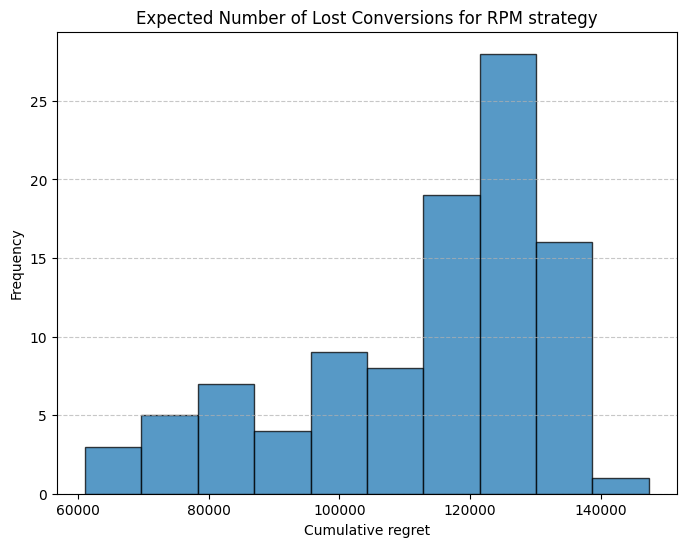

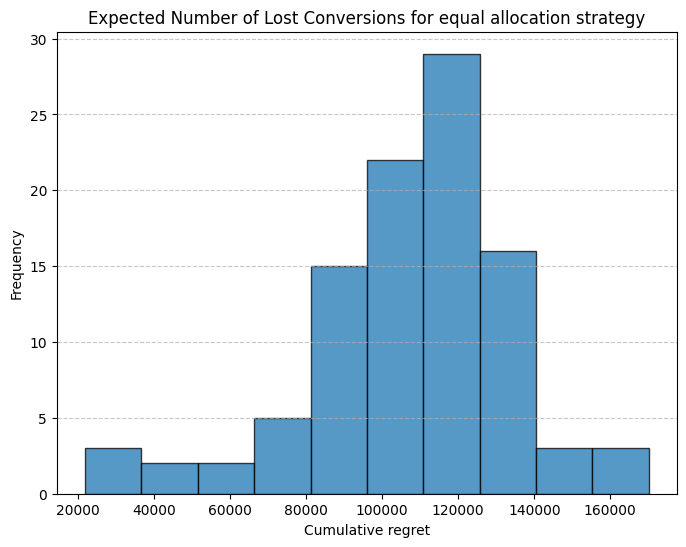

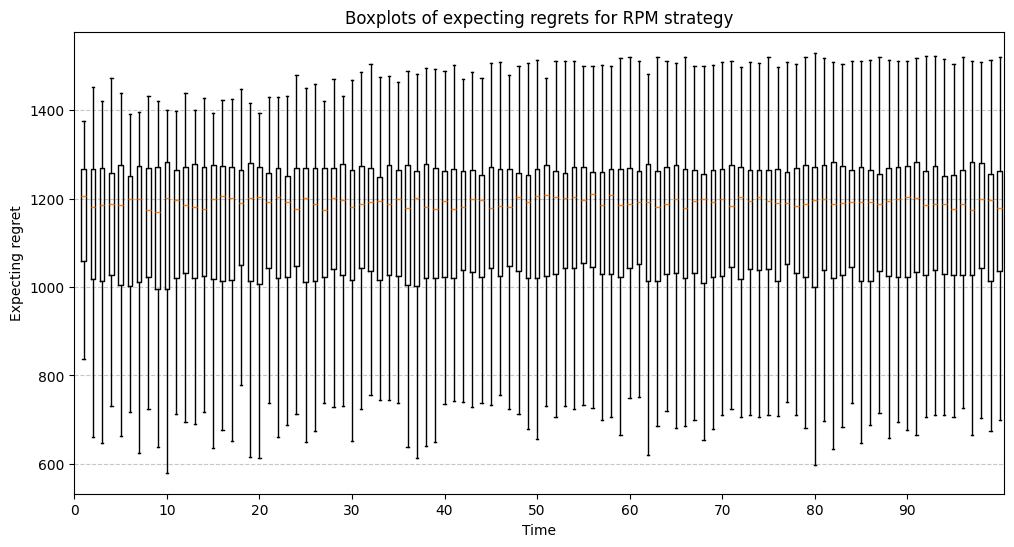

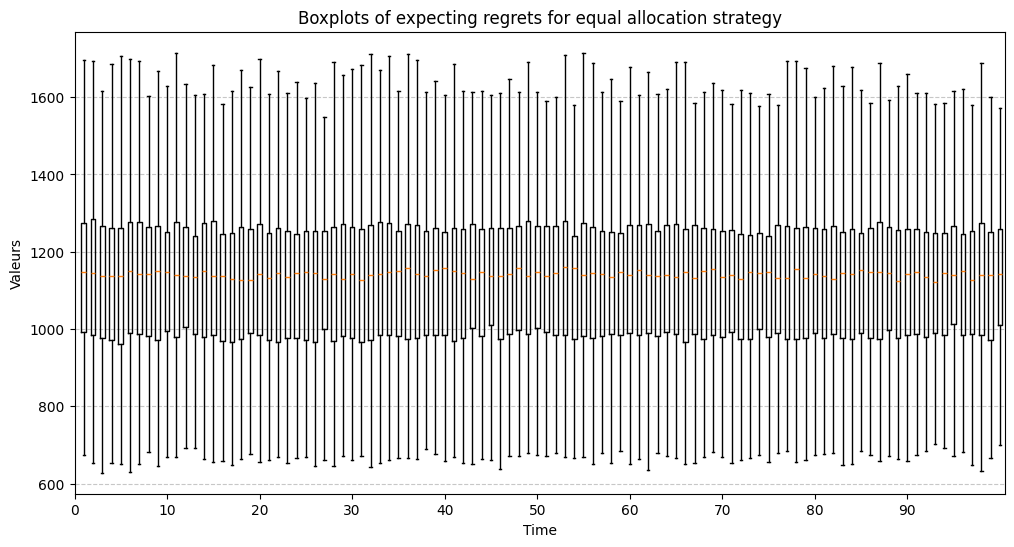

[0.094 0.009 0.052 0.253 0.047 0.022 0.064 0.029 0.312 0.118]


In [47]:
import numpy as np
import matplotlib.pyplot as plt
# Paramètres du problème
#np.random.seed(42)
n_arms = 10
n_trials = 100
n_experiments = 100
n_modalities = 3

# Générer les vraies probabilités de succès
true_success_probs = np.random.normal(0, 1, n_modalities)

rpm_regrets = []
rpm_cumulative_regrets = []
equal_allocation_regrets = []
equal_allocation_cumulative_regrets = []


for _ in range(n_experiments):
    print(_)
    rpm_regret, rpm_cumulative_regret, win_probs = linear_bandit_experiment(n_arms, n_modalities, n_trials, true_success_probs, strategy="rpm")
    rpm_regrets.append(rpm_regret)
    rpm_cumulative_regrets.append(rpm_cumulative_regret)

    equal_allocation_regret, equal_allocation_cumulative_regret, win_probs = linear_bandit_experiment(n_arms, n_modalities, n_trials, true_success_probs, strategy="equal allocation")
    equal_allocation_regrets.append(equal_allocation_regret)
    equal_allocation_cumulative_regrets.append(equal_allocation_cumulative_regret)

print(win_probs)

# Tracer l'histogramme
plt.figure(figsize=(8, 6))
plt.hist(rpm_cumulative_regrets, bins=10, edgecolor='black', alpha=0.75)
plt.title("Expected Number of Lost Conversions for RPM strategy")
plt.xlabel("Cumulative regret")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Tracer l'histogramme
plt.figure(figsize=(8, 6))
plt.hist(equal_allocation_cumulative_regrets, bins=10, edgecolor='black', alpha=0.75)
plt.title("Expected Number of Lost Conversions for equal allocation strategy")
plt.xlabel("Cumulative regret")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Regrouper les données par période
def group_by_period(experiment_data):
  period_data = [[] for _ in range(max(len(lst) for lst in experiment_data))]
  for lst in experiment_data:
      for i, value in enumerate(lst):
          period_data[i].append(value)
  return period_data
rpm_period_data = group_by_period(rpm_regrets)
equal_allocation_period_data = group_by_period(equal_allocation_regrets)


# Créer le boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(rpm_period_data, showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplots of expecting regrets for RPM strategy")
plt.xlabel("Time")
plt.ylabel("Expecting regret")
plt.xticks(ticks=range(0, 100, 10), labels=range(0, 100, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Créer le boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(equal_allocation_period_data, showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplots of expecting regrets for equal allocation strategy")
plt.xlabel("Time")
plt.ylabel("Valeurs")
plt.xticks(ticks=range(0, 100, 10), labels=range(0, 100, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(win_probs)

In [48]:
true_success_probs

array([-0.20898942, -1.29013119,  0.31130956])

0


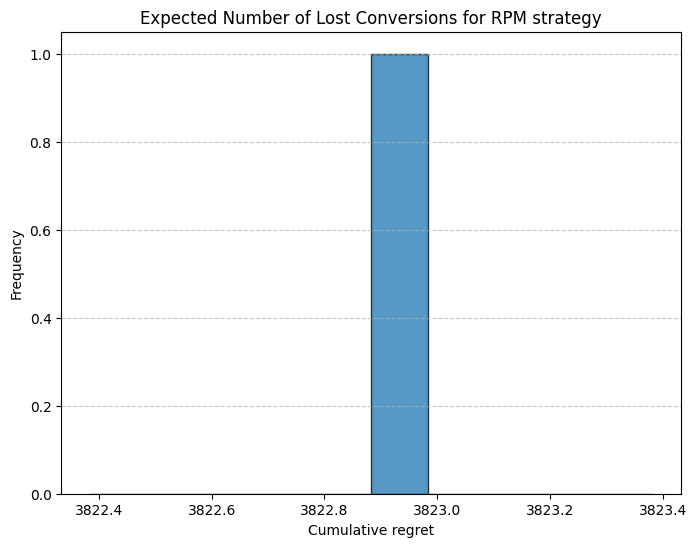

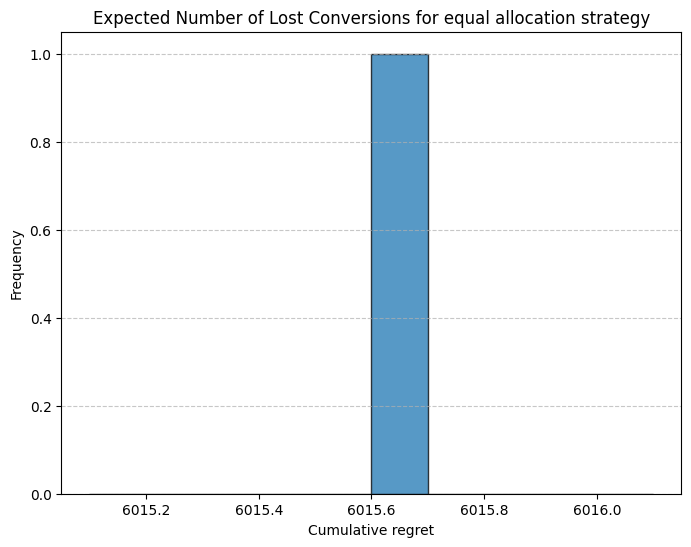

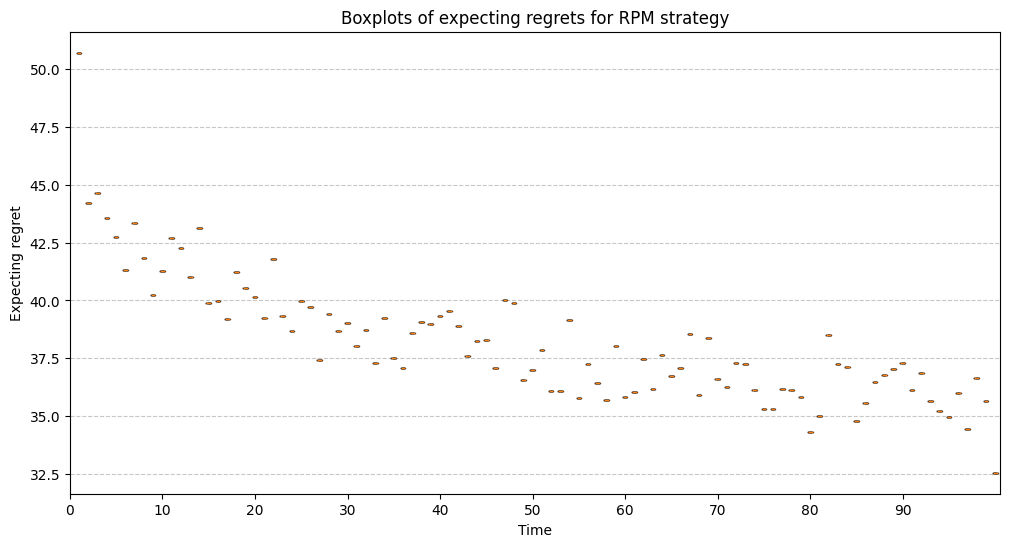

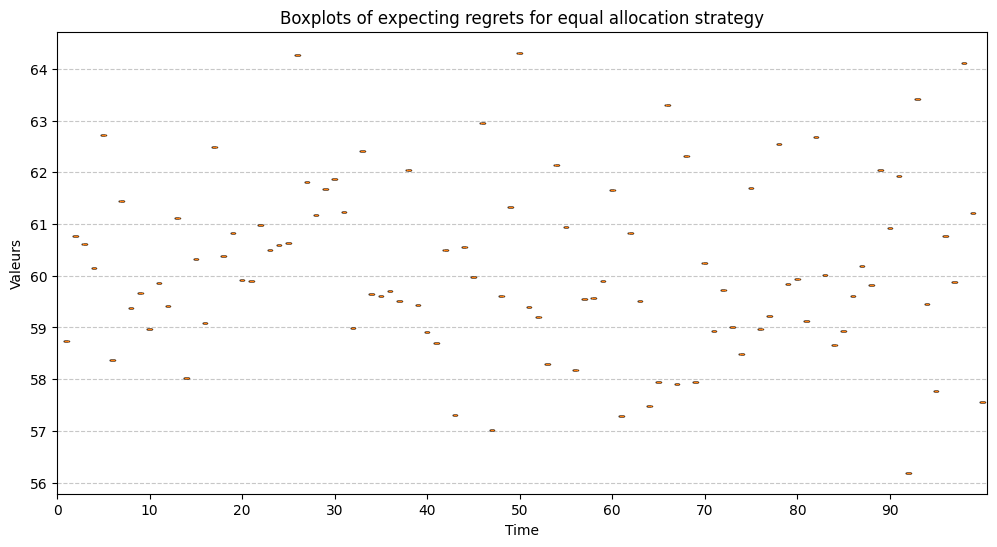

[0.052 0.058 0.088 0.019 0.082 0.04  0.324 0.026 0.22  0.091]


In [39]:
import numpy as np
import matplotlib.pyplot as plt
# Paramètres du problème
#np.random.seed(42)
n_arms = 10
n_trials = 100
n_experiments = 1
n_modalities = 3

# Générer les vraies probabilités de succès
true_success_probs = np.random.uniform(0, 1/10, n_modalities)

rpm_regrets = []
rpm_cumulative_regrets = []
equal_allocation_regrets = []
equal_allocation_cumulative_regrets = []


for _ in range(n_experiments):
    print(_)
    rpm_regret, rpm_cumulative_regret, win_probs = linear_bandit_experiment(n_arms, n_modalities, n_trials, true_success_probs, strategy="rpm")
    rpm_regrets.append(rpm_regret)
    rpm_cumulative_regrets.append(rpm_cumulative_regret)

    equal_allocation_regret, equal_allocation_cumulative_regret, win_probs = linear_bandit_experiment(n_arms, n_modalities, n_trials, true_success_probs, strategy="equal allocation")
    equal_allocation_regrets.append(equal_allocation_regret)
    equal_allocation_cumulative_regrets.append(equal_allocation_cumulative_regret)



# Tracer l'histogramme
plt.figure(figsize=(8, 6))
plt.hist(rpm_cumulative_regrets, bins=10, edgecolor='black', alpha=0.75)
plt.title("Expected Number of Lost Conversions for RPM strategy")
plt.xlabel("Cumulative regret")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Tracer l'histogramme
plt.figure(figsize=(8, 6))
plt.hist(equal_allocation_cumulative_regrets, bins=10, edgecolor='black', alpha=0.75)
plt.title("Expected Number of Lost Conversions for equal allocation strategy")
plt.xlabel("Cumulative regret")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Regrouper les données par période
def group_by_period(experiment_data):
  period_data = [[] for _ in range(max(len(lst) for lst in experiment_data))]
  for lst in experiment_data:
      for i, value in enumerate(lst):
          period_data[i].append(value)
  return period_data
rpm_period_data = group_by_period(rpm_regrets)
equal_allocation_period_data = group_by_period(equal_allocation_regrets)


# Créer le boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(rpm_period_data, showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplots of expecting regrets for RPM strategy")
plt.xlabel("Time")
plt.ylabel("Expecting regret")
plt.xticks(ticks=range(0, 100, 10), labels=range(0, 100, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Créer le boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(equal_allocation_period_data, showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplots of expecting regrets for equal allocation strategy")
plt.xlabel("Time")
plt.ylabel("Valeurs")
plt.xticks(ticks=range(0, 100, 10), labels=range(0, 100, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(win_probs)